In [6]:
save = False

In [7]:
#import packages
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from statannot import add_stat_annotation

In [8]:
# import from other scripts
import plot_utils
import stats_utils

In [9]:
model_identifier = "gpt2-xl"
outdir = os.path.abspath(os.path.join(os.getcwd(), 'results_paper/robustness'))

# get score frames

In [10]:
frames = []
for testonperturbed in [True, False]:
    for emb_context in ["Passage", "Sentence"]:
        condition_name1 = "TrainIntact-TestPerturbed" if testonperturbed else "TrainPerturbed-TestPerturbed"
        condition_name2 = "contextualized" if emb_context == "Passage" else "decontextualized"
        condition_name = f"{condition_name1}:{condition_name2}"
        print(condition_name)
        curr_df = plot_utils.get_best_scores_df(model_identifier, emb_context=emb_context, split_coord="Sentence", testonperturbed=testonperturbed)
        curr_df["score_conditions"] = [condition_name] * len(curr_df)
        frames.append(curr_df)
full_df = pd.concat(frames)

TrainIntact-TestPerturbed:contextualized
TrainIntact-TestPerturbed:decontextualized
TrainPerturbed-TestPerturbed:contextualized
TrainPerturbed-TestPerturbed:decontextualized


In [11]:
full_df

,score,error,condition,category,score_conditions
0,1.107199,0.141840,original,original,TrainIntact-TestPerturbed:contextualized
1,1.019374,0.120393,scrambled1,word-order,TrainIntact-TestPerturbed:contextualized
2,0.924364,0.086006,scrambled3,word-order,TrainIntact-TestPerturbed:contextualized
3,0.907545,0.071722,scrambled5,word-order,TrainIntact-TestPerturbed:contextualized
4,0.914475,0.099400,scrambled7,word-order,TrainIntact-TestPerturbed:contextualized
...,...,...,...,...,...
12,0.110841,0.062935,functionwords,information-loss,TrainPerturbed-TestPerturbed:decontextualized
13,0.658524,0.158579,sent_passage,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized
14,0.216358,0.055461,sent_topic,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized
15,0.073289,0.073522,sent_random,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized


In [12]:
full_df.loc[full_df["category"]=="original"]

,score,error,condition,category,score_conditions
0,1.107199,0.141840,original,original,TrainIntact-TestPerturbed:contextualized
0,0.767421,0.111384,original,original,TrainIntact-TestPerturbed:decontextualized
0,1.107199,0.141840,original,original,TrainPerturbed-TestPerturbed:contextualized
0,0.824291,0.128490,original,original,TrainPerturbed-TestPerturbed:decontextualized


# Plot

In [13]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }

sns.set_theme(font_scale=2.5, style="white", rc=custom_params)

In [14]:
#Rename conditions according to new names:
full_df['condition'] = full_df['condition'].map(plot_utils.COND2LABEL)
full_df['condition'] = full_df['condition'].replace(
        {'RandSentFromPassage': 'RandSent\nFromPassage',
         'RandSentFromTopic': 'RandSent\nFromTopic'})

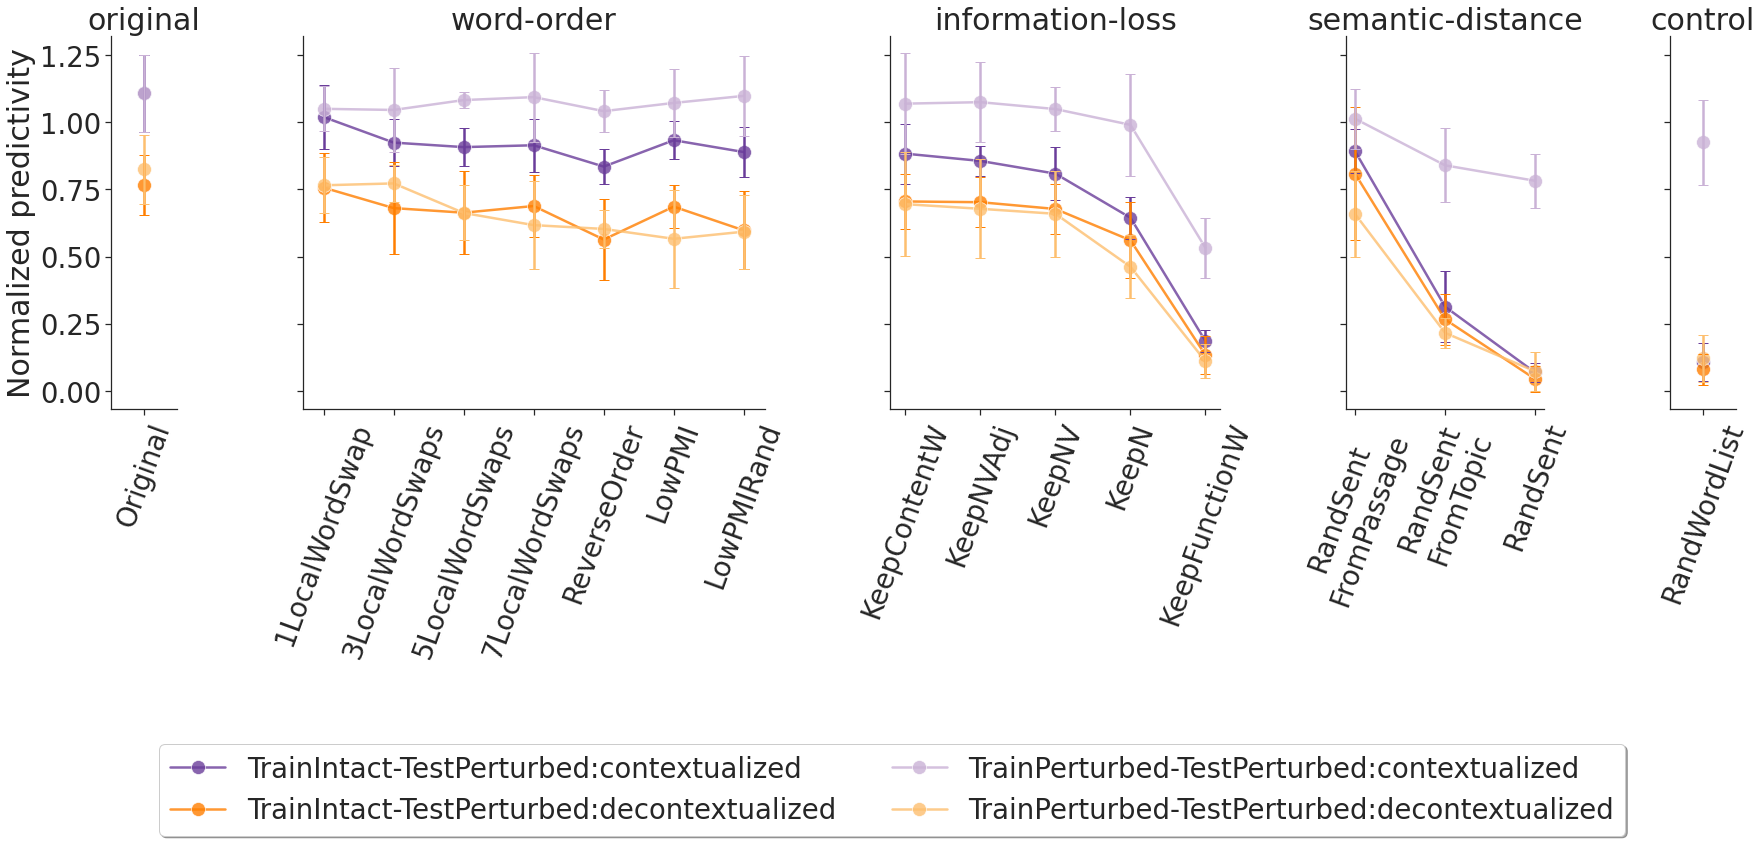

In [15]:
#get proportions for subplot width
CAT2COND, COND2CAT = plot_utils.get_conditions()
categories = CAT2COND.keys()
props = [len(full_df.loc[full_df["category"] == cat])/len(full_df) for cat in categories]

palette = [sns.color_palette('Paired')[9], sns.color_palette('Paired')[7],
           sns.color_palette('Paired')[8], sns.color_palette('Paired')[6],
          sns.color_palette("Set2")[0]]

g = sns.FacetGrid(full_df, col="category", sharex=False, hue="score_conditions",
                  gridspec_kws={"width_ratios": props},
                  height=10, aspect=0.5, palette=palette)

g.map(sns.lineplot, "condition", "score", alpha=0.8, markersize=14, marker="o", linewidth=2.5)
g.map(plt.errorbar, "condition", "score", "error", capsize=5, linewidth=2.5, ls='none')
g.set_xlabels("")
g.set_ylabels("Normalized predictivity")
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=70)
score_conditions = list(full_df["score_conditions"].unique())
# Put a legend below current axis
g.fig.legend(loc='upper center', labels=score_conditions,
          bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)

g.fig.tight_layout()

if save:
    plt.savefig(f'{outdir}/lineplot.svg', dpi=180, bbox_inches='tight')
    plt.savefig(f'{outdir}/lineplot.png', dpi=180, bbox_inches='tight')

plt.show()

# Stats

In [16]:
stats_frames = []
for testonperturbed in [True, False]:
    for emb_context in ["Passage", "Sentence"]:
        condition_name1 = "TrainIntact-TestPerturbed" if testonperturbed else "TrainPerturbed-TestPerturbed"
        condition_name2 = "contextualized" if emb_context == "Passage" else "decontextualized"
        condition_name = f"{condition_name1}:{condition_name2}"
        print(condition_name)
        curr_stats_df = stats_utils.get_stats_df(model_identifier, emb_context=emb_context, split_coord="Sentence", testonperturbed=testonperturbed)
        curr_stats_df["score_conditions"] = [condition_name] * len(curr_stats_df)
        stats_frames.append(curr_stats_df)
full_stats_df = pd.concat(stats_frames).reset_index(drop=True)

TrainIntact-TestPerturbed:contextualized
TrainIntact-TestPerturbed:decontextualized
TrainPerturbed-TestPerturbed:contextualized
TrainPerturbed-TestPerturbed:decontextualized


In [17]:
full_stats_df

,condition,values,category,score_conditions
0,original,0.357018,original,TrainIntact-TestPerturbed:contextualized
1,original,0.308316,original,TrainIntact-TestPerturbed:contextualized
2,original,0.339043,original,TrainIntact-TestPerturbed:contextualized
3,original,0.395303,original,TrainIntact-TestPerturbed:contextualized
4,original,0.397626,original,TrainIntact-TestPerturbed:contextualized
...,...,...,...,...
675,random-wl,0.070267,control,TrainPerturbed-TestPerturbed:decontextualized
676,random-wl,-0.008173,control,TrainPerturbed-TestPerturbed:decontextualized
677,random-wl,-0.024310,control,TrainPerturbed-TestPerturbed:decontextualized
678,random-wl,0.060339,control,TrainPerturbed-TestPerturbed:decontextualized


In [18]:
def func(string):
    return "_".join(string.split(":"))

full_stats_df['score_conditions'] = full_stats_df['score_conditions'].apply(func)

In [19]:
# Plot arguments
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.55, 0.04, 0.3]}

In [20]:
# # correlation across all 17 conditions (170 datapoints because every condition has 10 subject scores)

# import scikit_posthocs as sp

# CAT2COND, COND2CAT = plot_utils.get_conditions()
# score_conditions = list(full_stats_df['score_conditions'])

# ttest = sp.posthoc_ttest(full_stats_df, val_col='values', group_col='score_conditions', p_adjust='fdr_bh')
# plt.figure(figsize=(10,10))
# sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
# plt.subplots_adjust(top=0.8) 

# ttest_df = pd.DataFrame(ttest)
# ttest_df.to_csv(f'{outdir}/stats_robustness_overall.csv')

# plt.savefig(f'{outdir}/stats_robustness_overall.svg', dpi=180)
# plt.savefig(f'{outdir}/stats_robustness_overall.png', dpi=180, bbox_inches='tight')

# plt.show()

In [21]:
# get correlation values
from scipy import stats
score_conditions = np.unique(list(full_stats_df['score_conditions']))
combinations = [(elm1, elm2) for elm1 in score_conditions for elm2 in score_conditions]
elms1, elms2, rs, ps = [],[],[],[]
for (elm1, elm2) in combinations:
    values1 = list(full_stats_df.loc[full_stats_df["score_conditions"] == elm1]["values"])
    values2 = list(full_stats_df.loc[full_stats_df["score_conditions"] == elm2]["values"])
    res = stats.pearsonr(values1,values2)
    print(f"{elm1} | {elm2} | {res}")
    elms1.append(elm1)
    elms2.append(elm2)
    rs.append(round(res[0],3))
    ps.append(round(res[1],3))
correlation_stats_df = pd.DataFrame({
    "Condition 1" : elms1,
    "Condition 2" : elms2,
    "Pearson r value" : rs,
    "p value" : ps
})

if save:
    correlation_stats_df.to_csv('results_paper/pairwise_correlations_robustness.csv', index=False)

TrainIntact-TestPerturbed_contextualized | TrainIntact-TestPerturbed_contextualized | (0.9999999999999998, 0.0)
TrainIntact-TestPerturbed_contextualized | TrainIntact-TestPerturbed_decontextualized | (0.9182090326072787, 1.8019000948203158e-69)
TrainIntact-TestPerturbed_contextualized | TrainPerturbed-TestPerturbed_contextualized | (0.623762844646405, 1.0289056876839641e-19)
TrainIntact-TestPerturbed_contextualized | TrainPerturbed-TestPerturbed_decontextualized | (0.8657119981673543, 2.2724186676763445e-52)
TrainIntact-TestPerturbed_decontextualized | TrainIntact-TestPerturbed_contextualized | (0.9182090326072787, 1.8019000948203158e-69)
TrainIntact-TestPerturbed_decontextualized | TrainIntact-TestPerturbed_decontextualized | (0.9999999999999998, 0.0)
TrainIntact-TestPerturbed_decontextualized | TrainPerturbed-TestPerturbed_contextualized | (0.5697918077607399, 5.099201807941894e-16)
TrainIntact-TestPerturbed_decontextualized | TrainPerturbed-TestPerturbed_decontextualized | (0.832940

In [22]:
print(f'Average: {np.mean(rs)} | {np.mean(ps)}')

Average: 0.814125 | 0.0


In [23]:
for (elm1, elm2) in combinations:
    avg_values1 = np.mean(list(full_stats_df.loc[full_stats_df["score_conditions"] == elm1]["values"]))
    avg_values2 = np.mean(list(full_stats_df.loc[full_stats_df["score_conditions"] == elm2]["values"]))
    difference = avg_values1 - avg_values2
    print(f"{elm1} | {elm2} | {difference}")

TrainIntact-TestPerturbed_contextualized | TrainIntact-TestPerturbed_contextualized | 0.0
TrainIntact-TestPerturbed_contextualized | TrainIntact-TestPerturbed_decontextualized | 0.0616653601462461
TrainIntact-TestPerturbed_contextualized | TrainPerturbed-TestPerturbed_contextualized | -0.08473340767531293
TrainIntact-TestPerturbed_contextualized | TrainPerturbed-TestPerturbed_decontextualized | 0.06419366461097184
TrainIntact-TestPerturbed_decontextualized | TrainIntact-TestPerturbed_contextualized | -0.0616653601462461
TrainIntact-TestPerturbed_decontextualized | TrainIntact-TestPerturbed_decontextualized | 0.0
TrainIntact-TestPerturbed_decontextualized | TrainPerturbed-TestPerturbed_contextualized | -0.14639876782155903
TrainIntact-TestPerturbed_decontextualized | TrainPerturbed-TestPerturbed_decontextualized | 0.002528304464725739
TrainPerturbed-TestPerturbed_contextualized | TrainIntact-TestPerturbed_contextualized | 0.08473340767531293
TrainPerturbed-TestPerturbed_contextualized |

# Do same within category

In [24]:
# import scikit_posthocs as sp

# CAT2COND, COND2CAT = plot_utils.get_conditions()
# score_conditions = list(full_stats_df['score_conditions'])

# for category in CAT2COND.keys():
#     print(category)
#     sub_df = full_stats_df.loc[full_stats_df["category"] == category]
#     print(len(sub_df))
#     ttest = sp.posthoc_ttest(sub_df, val_col='values', group_col='score_conditions', p_adjust='fdr_bh')
        
#     plt.figure(figsize=(10,10))
#     sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
#     plt.subplots_adjust(top=0.8) 
#     plt.title(f'{category}')
    
#     ttest_df = pd.DataFrame(ttest)
#     ttest_df["manipulation"] = [f"{category}"] * len(ttest_df)
#     ttest_df.to_csv(f'{outdir}/stats_robustness_{category}.csv')
    
#     plt.savefig(f'{outdir}/stats_robustness_{category}.svg', dpi=180, bbox_inches='tight')
#     plt.savefig(f'{outdir}/stats_robustness_{category}.png', dpi=180, bbox_inches='tight')

#     plt.show()


In [25]:
import scipy
from tqdm import tqdm
import statsmodels

CAT2COND, COND2CAT = plot_utils.get_conditions()
score_conditions = list(full_stats_df['score_conditions'].unique())

with_ttest_frames = []

for category in CAT2COND.keys():
    
    already_tested = [] #list to keep track of which combos were already tested (for correct number of multiple comparisons)
    # NOTE: only done for half of the comparisons, i.e., upper triangle of comparison matrix
    # https://github.com/maximtrp/scikit-posthocs/blob/master/scikit_posthocs/_posthocs.py#L1653
    
    ttests, pvals = [], []
    compare1, compare2 = [], []
    cohens_d = []
    
    subdf = full_stats_df.loc[full_stats_df["category"] == category]
    
    for sc1 in score_conditions:
        sc1_scores = list(subdf[subdf['score_conditions'] == sc1]["values"])
        
        for sc2 in score_conditions:
            
            if sc1 == sc2:
                continue
            
            if set([sc1, sc2]) in already_tested:
                print(f"Already tested the comparison {sc1} & {sc2}")
                continue
            else:
                sc2_scores = list(subdf[subdf['score_conditions'] == sc2]["values"])

                #get ttest
                ttest, pval = scipy.stats.ttest_ind(sc1_scores, sc2_scores)
                #get cohens d
                cohensd = stats_utils.cohens_d(sc1_scores, sc2_scores)

                ttests.append(round(ttest,3))
                pvals.append(pval)
                compare1.append(sc1)
                compare2.append(sc2)
                cohens_d.append(cohensd)

                already_tested.append(set([sc1, sc2]))
    
    _, adjusted_pvals = statsmodels.stats.multitest.fdrcorrection(pvals)
    adjusted_pvals = [round(x,3) for x in adjusted_pvals]
    significances = stats_utils.assign_significance_labels(adjusted_pvals)
    
    adjusted_pvals = [round(x,3) for x in adjusted_pvals]
    pvals = [round(x,3) for x in pvals]
    cohens_d = [round(x,3) for x in cohens_d]
    significances = stats_utils.assign_significance_labels(adjusted_pvals) 
    
    ttest_df = pd.DataFrame({
        "Experimental Design 1" : compare1,
        "Experimental Design 2" : compare2,
        "T-test statistic" : ttests,
        "Adjusted pvalue" : adjusted_pvals,
        "Significance" : significances,
        "Cohen's d" : cohens_d,
        "Unadjusted p value" : pvals
    })
    ttest_df["Manipulation"] = category
    #print(ttest_df)
    ttest_df.to_csv(f'{outdir}/stats_robustness_{category}_withttest.csv', index=False)
    
    with_ttest_frames.append(ttest_df)
    
combined_with_ttest_frame = pd.concat(with_ttest_frames)

if save:
    combined_with_ttest_frame.to_csv(f'{outdir}/stats_robustness_withttest_ALL.csv', index=False)


Already tested the comparison TrainIntact-TestPerturbed_decontextualized & TrainIntact-TestPerturbed_contextualized
Already tested the comparison TrainPerturbed-TestPerturbed_contextualized & TrainIntact-TestPerturbed_contextualized
Already tested the comparison TrainPerturbed-TestPerturbed_contextualized & TrainIntact-TestPerturbed_decontextualized
Already tested the comparison TrainPerturbed-TestPerturbed_decontextualized & TrainIntact-TestPerturbed_contextualized
Already tested the comparison TrainPerturbed-TestPerturbed_decontextualized & TrainIntact-TestPerturbed_decontextualized
Already tested the comparison TrainPerturbed-TestPerturbed_decontextualized & TrainPerturbed-TestPerturbed_contextualized
Already tested the comparison TrainIntact-TestPerturbed_decontextualized & TrainIntact-TestPerturbed_contextualized
Already tested the comparison TrainPerturbed-TestPerturbed_contextualized & TrainIntact-TestPerturbed_contextualized
Already tested the comparison TrainPerturbed-TestPert

## Stats within condition manipulation for each factor analysis

In [26]:
def adjust_name(cond):
    #adjust names for consistency
    if cond == 'sentenceshuffle_random':
        cond = 'sent_random'
    elif cond == 'sentenceshuffle_passage':
        cond = 'sent_passage'
    elif cond == 'sentenceshuffle_topic':
        cond = 'sent_topic'
    return cond

In [27]:
import scipy
import statsmodels

#Benjamini/Hochberg corrected
def get_ttest_results(model_identifier, emb_context="Passage", split_coord="Sentence",
                testonperturbed=False, category=None, randomnouns=False):
    
    subdf = stats_utils.get_stats_df(model_identifier=model_identifier, emb_context=emb_context,
                                     split_coord=split_coord, testonperturbed=testonperturbed,
                                    randomnouns = randomnouns)
    
    pvals2original, pvals2random = [], []
    ttest2original, ttest2random = [], []
    cohensd2original, cohensd2random = [], []
    conds = []
    
    for ind, cond in enumerate(CAT2COND[category]):
        
        #adjust names for consistency
        cond = adjust_name(cond)

        #get subject scores
        original_scores = list(subdf[subdf['condition'] == 'original']["values"])
        cond_scores = list(subdf[subdf['condition'] == cond]["values"])
        random_scores = list(subdf[subdf['condition'] == 'random-wl']["values"])
        
        if category=="word-order" and ind==0:
            #get ttest
            ttest, pval = scipy.stats.ttest_ind(original_scores, random_scores)
            # get effect size
            cohensd = stats_utils.cohens_d(original_scores, random_scores)
            print(f"ORIGINAL vs. RANDOM-WL \nttest: {ttest} \npval: {pval} \ncohen's d: {cohensd}")
        
        #get ttest
        ttest2orig, pval2orig = scipy.stats.ttest_ind(original_scores,cond_scores)
        ttest2rand, pval2rand = scipy.stats.ttest_ind(random_scores,cond_scores)
        
        # get effect size
        cohensd2orig = stats_utils.cohens_d(original_scores, cond_scores)
        cohensd2rand = stats_utils.cohens_d(random_scores, cond_scores)
        
        conds.append(cond)
        pvals2original.append(pval2orig)
        ttest2original.append(ttest2orig)
        pvals2random.append(pval2rand)
        ttest2random.append(ttest2rand)
        cohensd2original.append(cohensd2orig)
        cohensd2random.append(cohensd2rand)
        
    # correct for multiple comparisons
    # statsmodels.stats.multitest.fdrcorrection(pvals) = statsmodels.stats.multitest.multipletests(pvals, method='fdr_bh')
    # first output is list of Booleans indicating whether to reject null hypothesis or not
    _, adjusted_pvals2original = statsmodels.stats.multitest.fdrcorrection(pvals2original)
    _, adjusted_pvals2random = statsmodels.stats.multitest.fdrcorrection(pvals2random)
    
    #assign significance levels
    significance2original = stats_utils.assign_significance_labels(adjusted_pvals2original)
    significance2random = stats_utils.assign_significance_labels(adjusted_pvals2random)
    
    
    stats_df = pd.DataFrame({
        "condition": conds,
        "ttest2original" : ttest2original,
        "ttest2random" : ttest2random,
        "adjusted_pvals2original" : adjusted_pvals2original,
        "adjusted_pvals2random" : adjusted_pvals2random,
        "cohensd2original" : cohensd2original,
        "cohensd2random" : cohensd2random,
        "significance2original" : significance2original,
        "significance2random" : significance2random,
        "pvals2original" : pvals2original,
        "pvals2random" : pvals2random
    })
    
    return stats_df

In [28]:
def get_within_cond_stats(model_identifier="gpt2-xl", emb_context="Passage", split_coord="Sentence",
                testonperturbed=False, randomnouns=False):
    frames = []
    for category in ["word-order", "information-loss", "semantic-distance"]:
        stats_df = get_ttest_results(model_identifier=model_identifier,
                          emb_context=emb_context,
                          split_coord=split_coord,
                          testonperturbed=testonperturbed,
                          category=category, randomnouns=randomnouns)
        frames.append(stats_df)
    within_cond_stats_df = pd.concat(frames)
    return within_cond_stats_df

In [29]:
frames = []
for testonperturbed in [True, False]:
    for emb_context in ["Passage", "Sentence"]:
        condition_name1 = "TrainIntact-TestPerturbed" if testonperturbed else "TrainPerturbed-TestPerturbed"
        condition_name2 = "contextualized" if emb_context == "Passage" else "decontextualized"
        condition_name = f"{condition_name1}:{condition_name2}"
        print(condition_name)
        curr_df = get_within_cond_stats(model_identifier, emb_context=emb_context, split_coord="Sentence", testonperturbed=testonperturbed)
        curr_df["score_conditions"] = condition_name
        frames.append(curr_df)
full_within_stats_df = pd.concat(frames)

TrainIntact-TestPerturbed:contextualized
ORIGINAL vs. RANDOM-WL 
ttest: 21.551496315951862 
pval: 2.64202883706845e-14 
cohen's d: 9.63812215586093
TrainIntact-TestPerturbed:decontextualized
ORIGINAL vs. RANDOM-WL 
ttest: 16.501337910179924 
pval: 2.5861752328344908e-12 
cohen's d: 7.379622657371325
TrainPerturbed-TestPerturbed:contextualized
ORIGINAL vs. RANDOM-WL 
ttest: 2.716300342507065 
pval: 0.014152760509998849 
cohen's d: 1.2147664426303515
TrainPerturbed-TestPerturbed:decontextualized
ORIGINAL vs. RANDOM-WL 
ttest: 14.928577223385956 
pval: 1.396156133500441e-11 
cohen's d: 6.6762626957692115


In [30]:
full_within_stats_df.head()

,condition,ttest2original,ttest2random,adjusted_pvals2original,adjusted_pvals2random,cohensd2original,cohensd2random,significance2original,significance2random,pvals2original,pvals2random,score_conditions
0,scrambled1,1.278297,-18.532649,0.217383,4.169681e-13,0.571672,-8.288052,n.s.,***,0.217383,3.574013e-13,TrainIntact-TestPerturbed:contextualized
1,scrambled3,3.415087,-21.212587,0.003601,9.795906e-14,1.527273,-9.486557,**,***,0.003087,3.478449e-14,TrainIntact-TestPerturbed:contextualized
2,scrambled5,3.644457,-20.845106,0.003245,9.795906e-14,1.629851,-9.322215,**,***,0.001854,4.708901e-14,TrainIntact-TestPerturbed:contextualized
3,scrambled7,3.668394,-20.637976,0.003245,9.795906e-14,1.640556,-9.229584,**,***,0.001758,5.597661e-14,TrainIntact-TestPerturbed:contextualized
4,backward,5.329610,-18.023275,0.000320,5.760193e-13,2.383474,-8.060254,***,***,0.000046,5.760193e-13,TrainIntact-TestPerturbed:contextualized


In [31]:
for sc in score_conditions:
    sub_df = full_within_stats_df.loc[full_within_stats_df["score_conditions"]==sc]
    print(sc)
    print(sub_df[['condition', 'significance2original', 'ttest2original', 'adjusted_pvals2original', 'cohensd2original']])
    print(sub_df[['condition', 'significance2random', 'ttest2random', 'adjusted_pvals2random', 'cohensd2random']])
    print("\n\n")

TrainIntact-TestPerturbed_contextualized
Empty DataFrame
Columns: [condition, significance2original, ttest2original, adjusted_pvals2original, cohensd2original]
Index: []
Empty DataFrame
Columns: [condition, significance2random, ttest2random, adjusted_pvals2random, cohensd2random]
Index: []



TrainIntact-TestPerturbed_decontextualized
Empty DataFrame
Columns: [condition, significance2original, ttest2original, adjusted_pvals2original, cohensd2original]
Index: []
Empty DataFrame
Columns: [condition, significance2random, ttest2random, adjusted_pvals2random, cohensd2random]
Index: []



TrainPerturbed-TestPerturbed_contextualized
Empty DataFrame
Columns: [condition, significance2original, ttest2original, adjusted_pvals2original, cohensd2original]
Index: []
Empty DataFrame
Columns: [condition, significance2random, ttest2random, adjusted_pvals2random, cohensd2random]
Index: []



TrainPerturbed-TestPerturbed_decontextualized
Empty DataFrame
Columns: [condition, significance2original, ttest2o

TrainIntact-TestPerturbed_contextualized
word-order
['scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'backward', 'lowpmi', 'lowpmi-random']


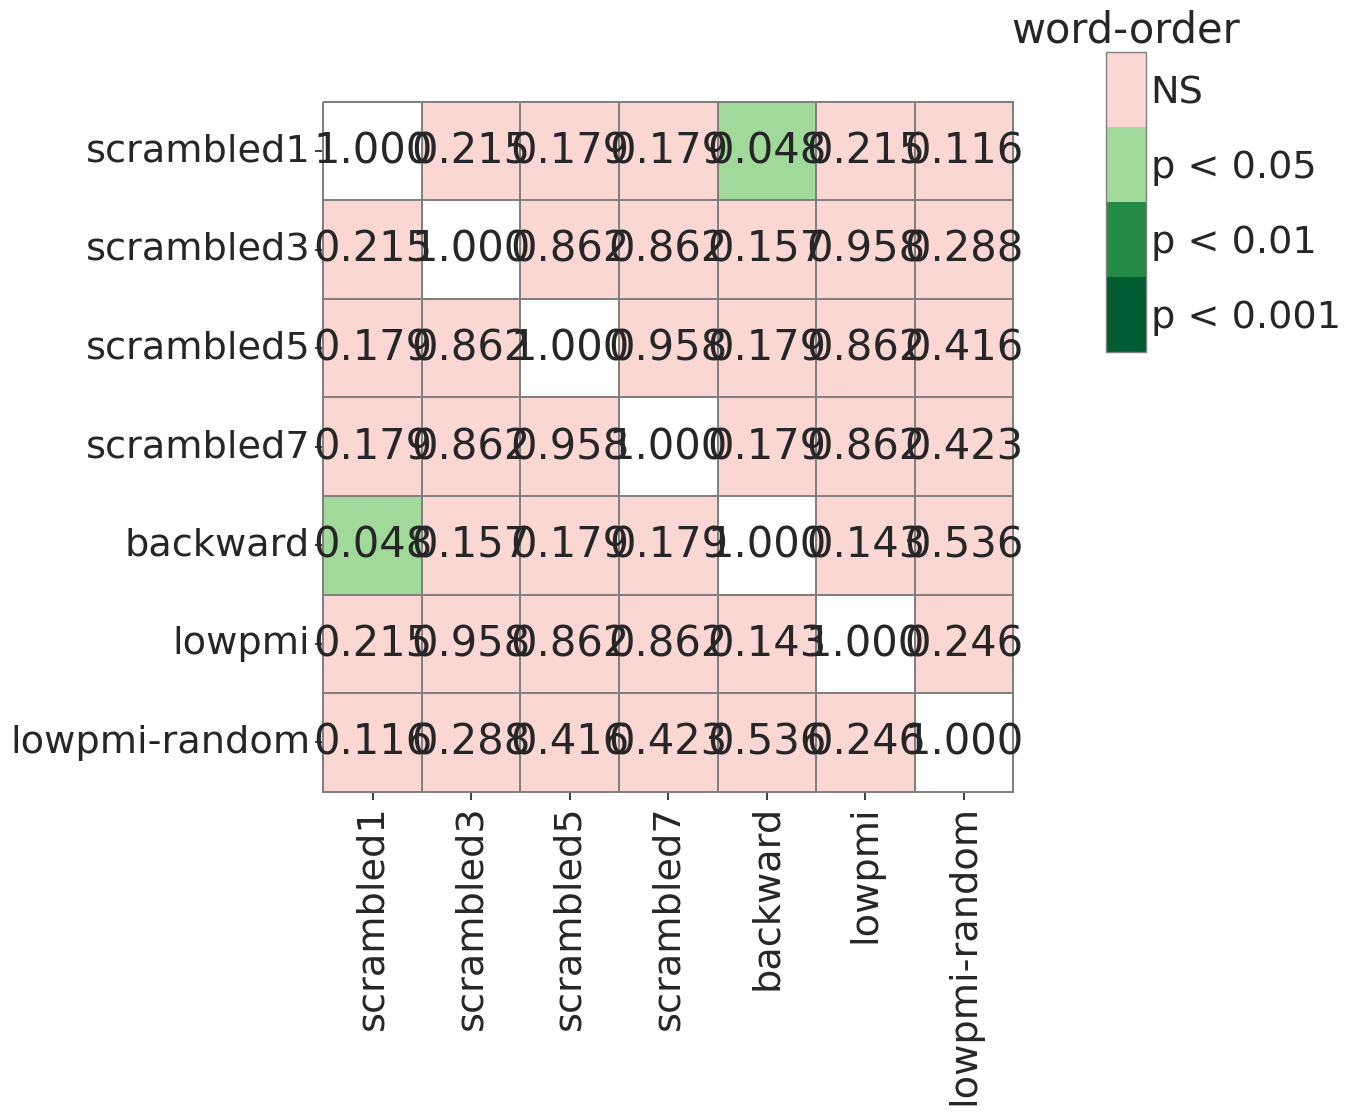

information-loss
['contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords']


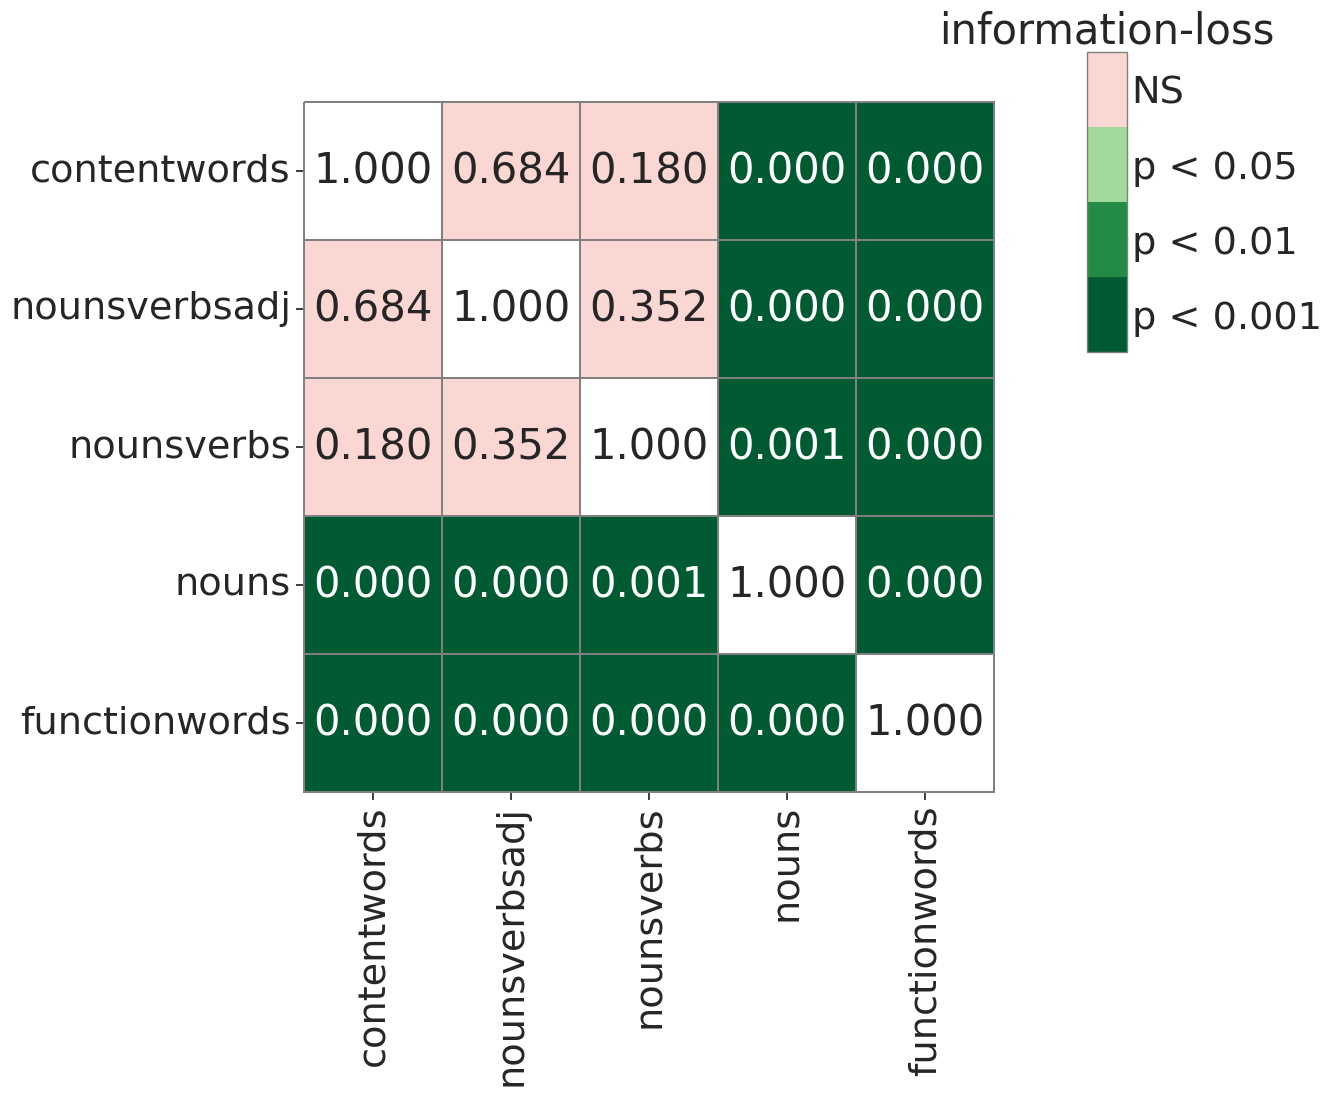

semantic-distance
['sent_passage', 'sent_topic', 'sent_random']


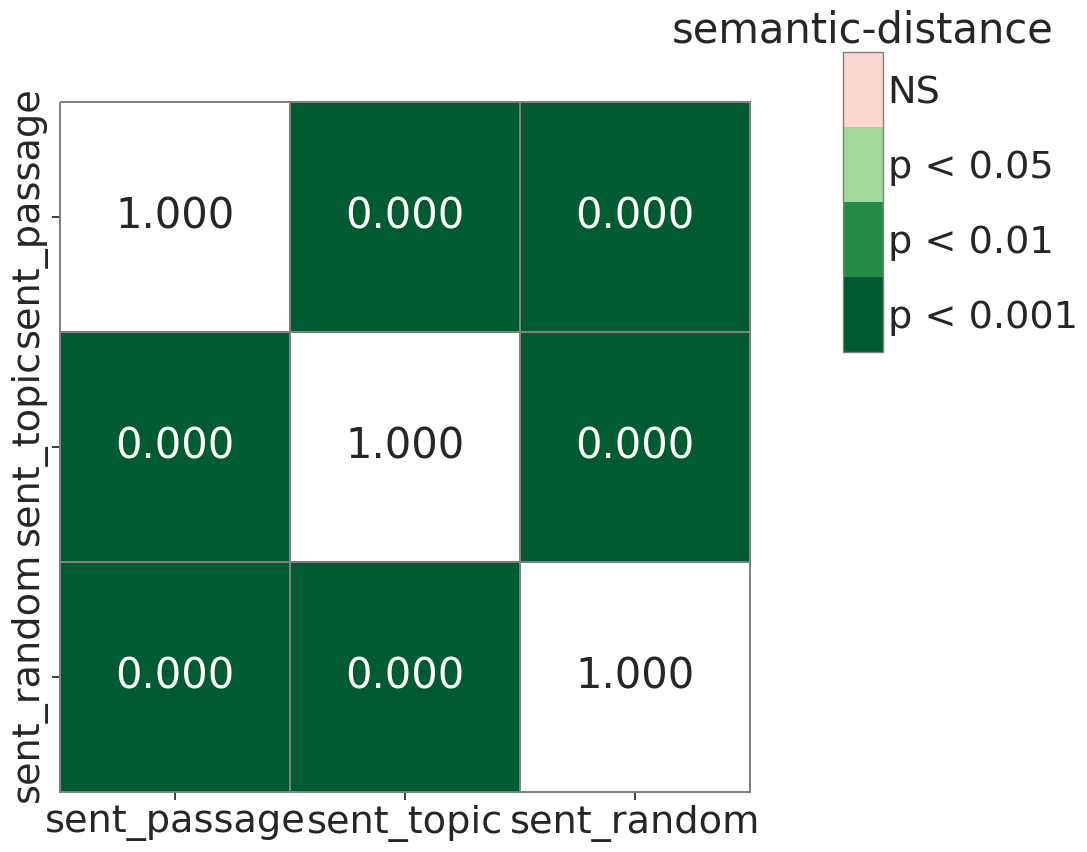

TrainIntact-TestPerturbed_decontextualized
word-order
['scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'backward', 'lowpmi', 'lowpmi-random']


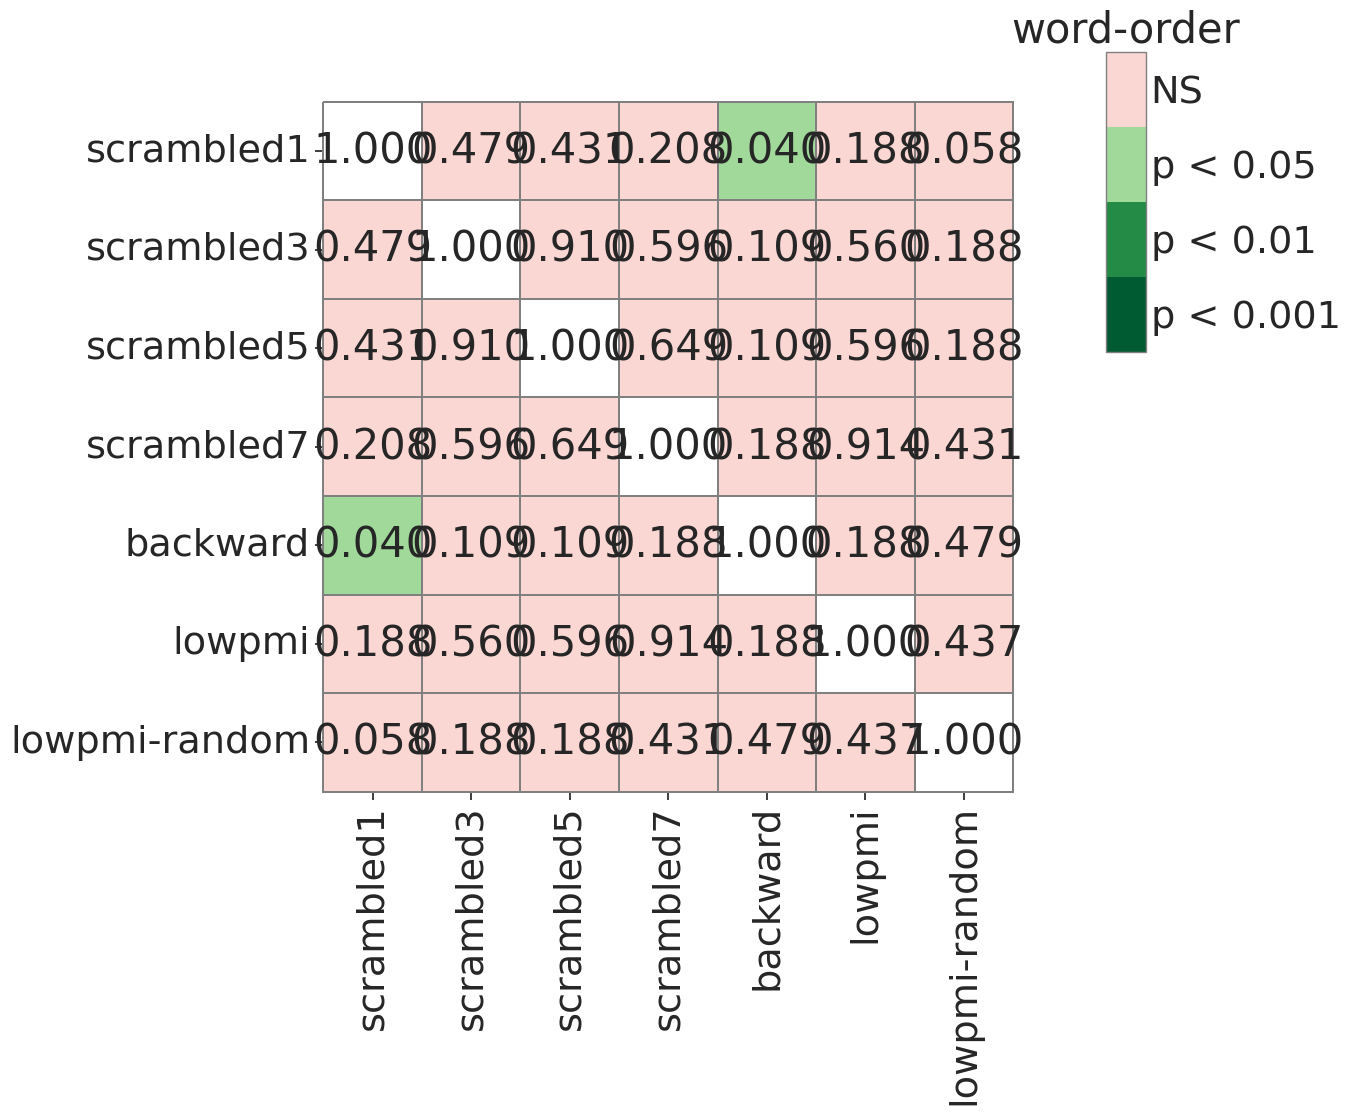

information-loss
['contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords']


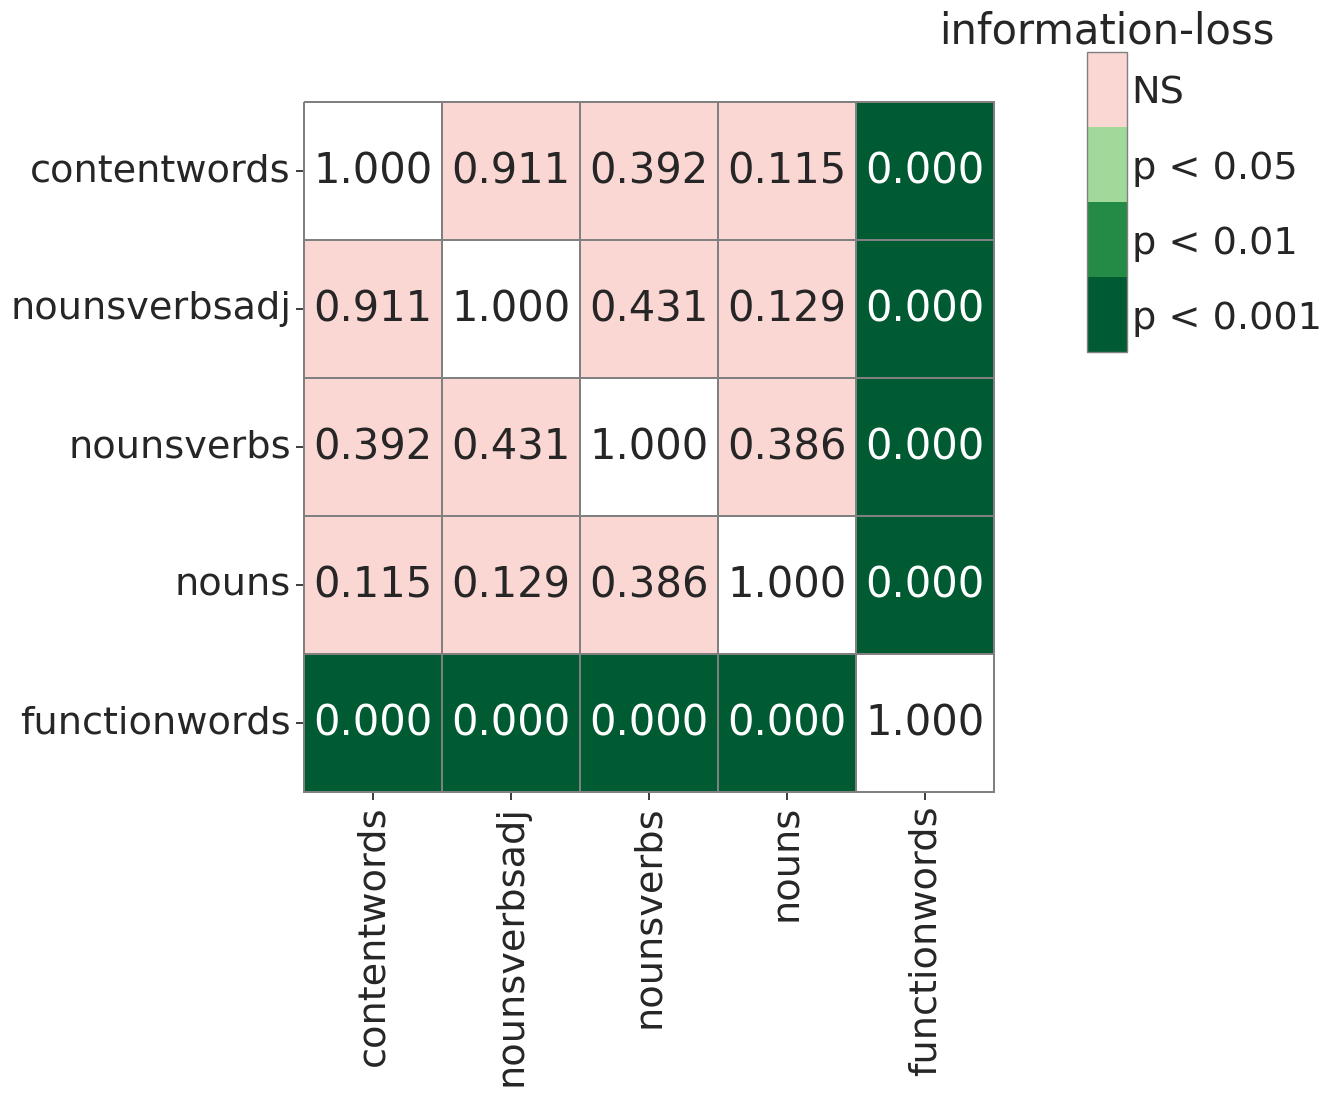

semantic-distance
['sent_passage', 'sent_topic', 'sent_random']


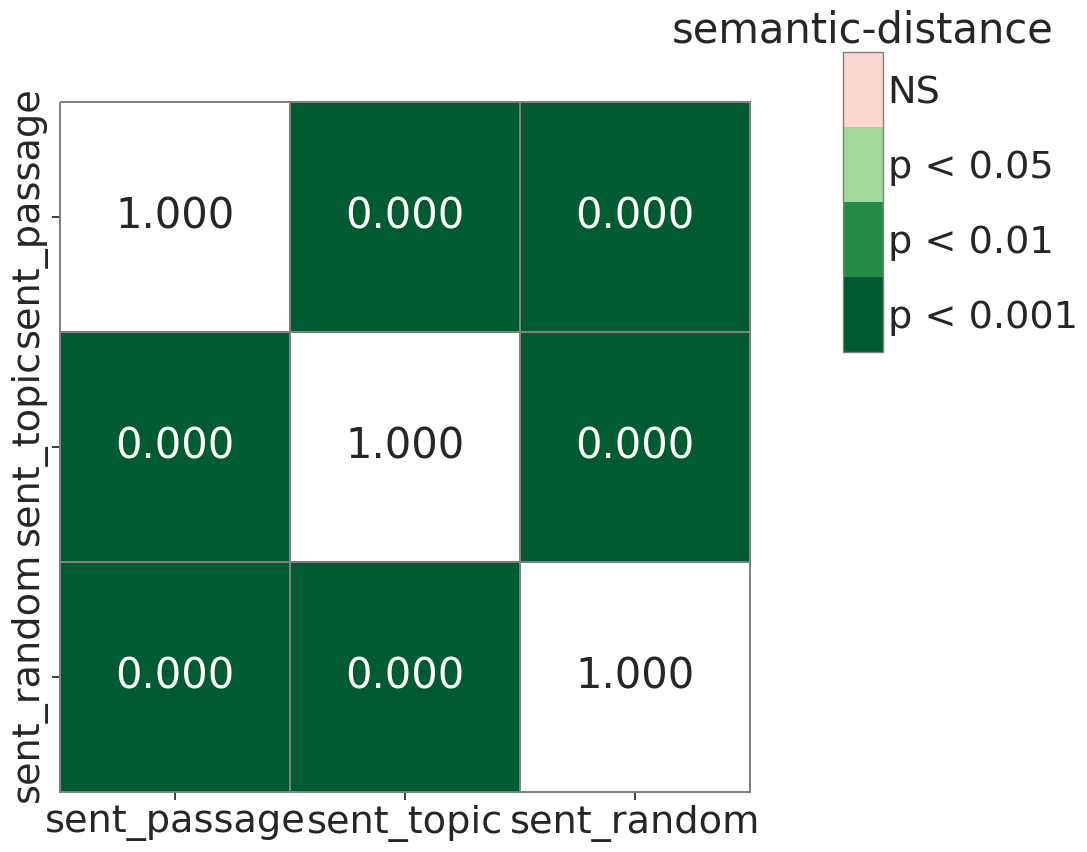

TrainPerturbed-TestPerturbed_contextualized
word-order
['scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'backward', 'lowpmi', 'lowpmi-random']


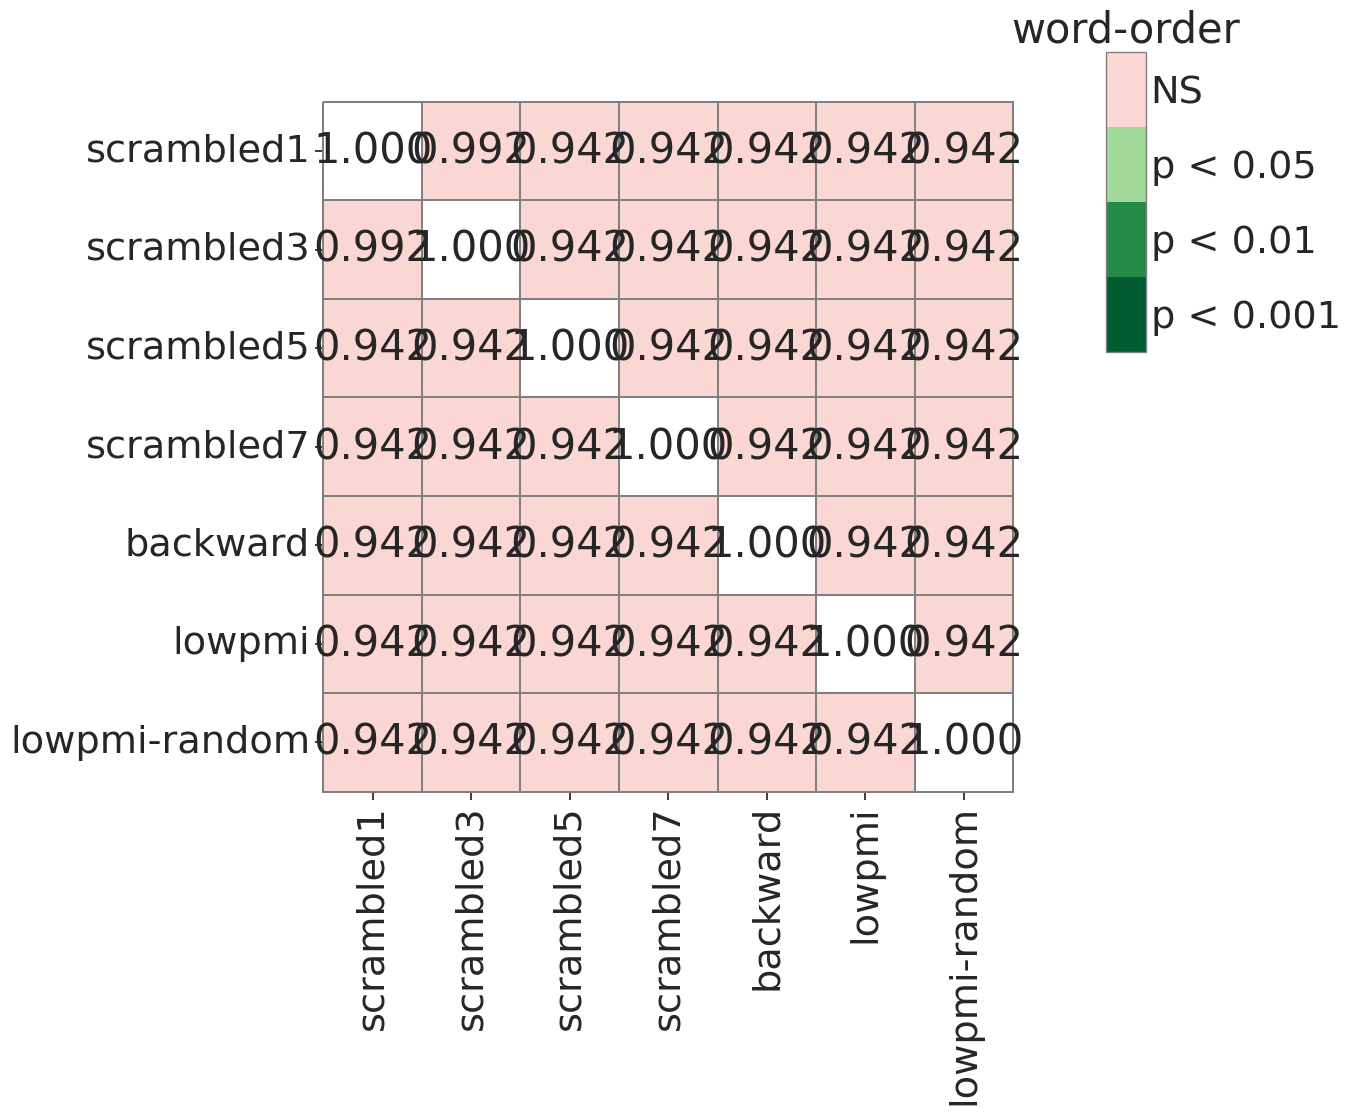

information-loss
['contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords']


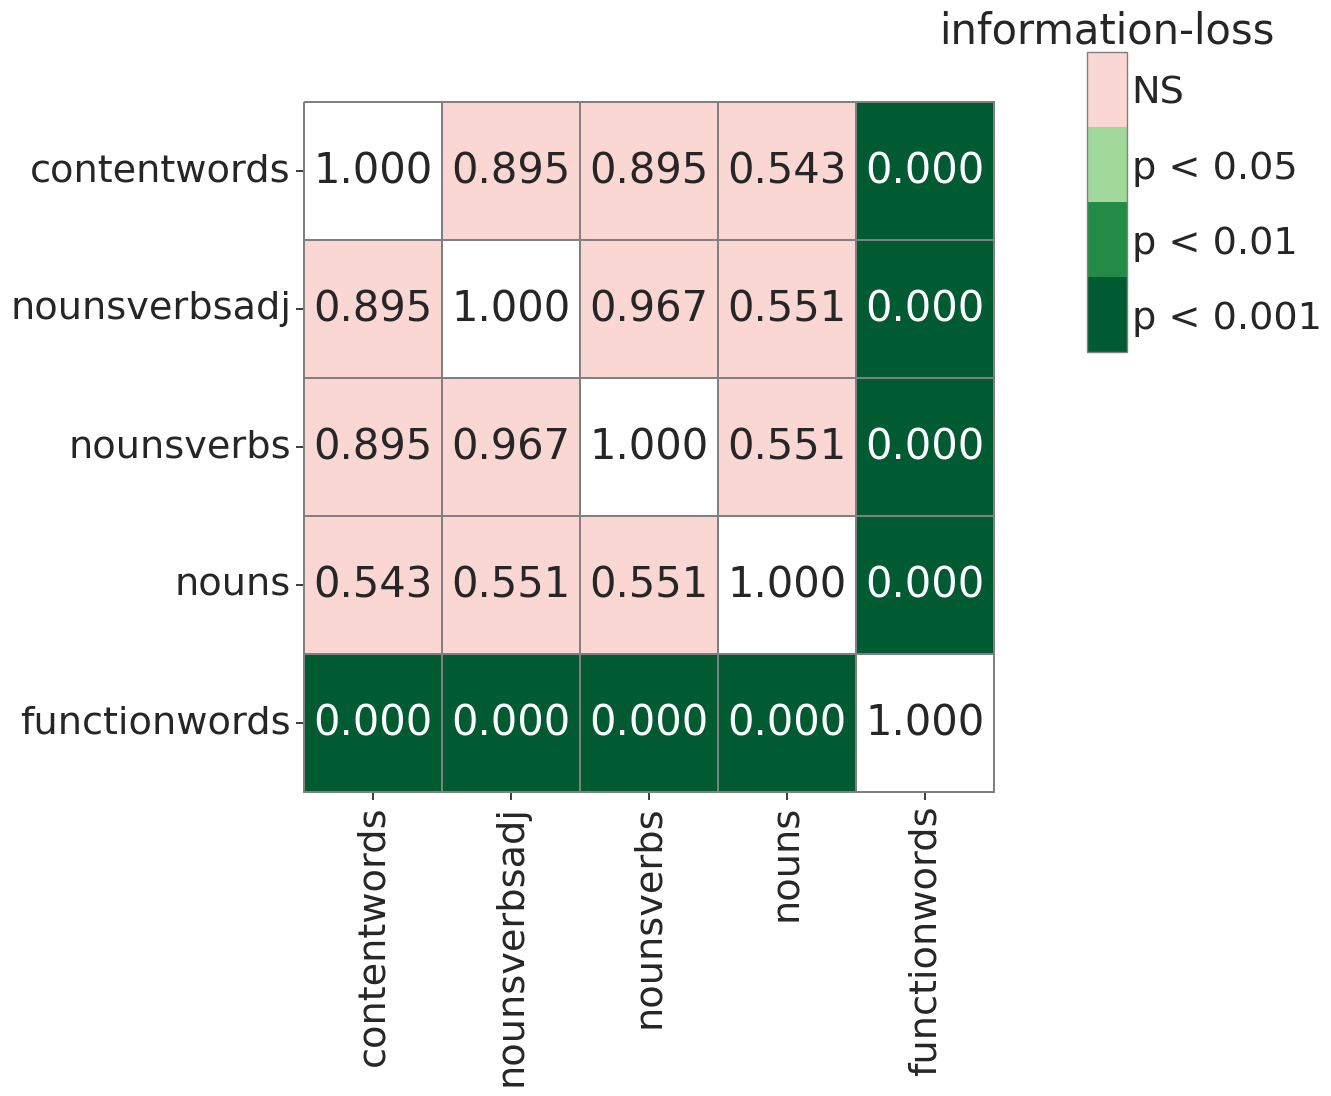

semantic-distance
['sent_passage', 'sent_topic', 'sent_random']


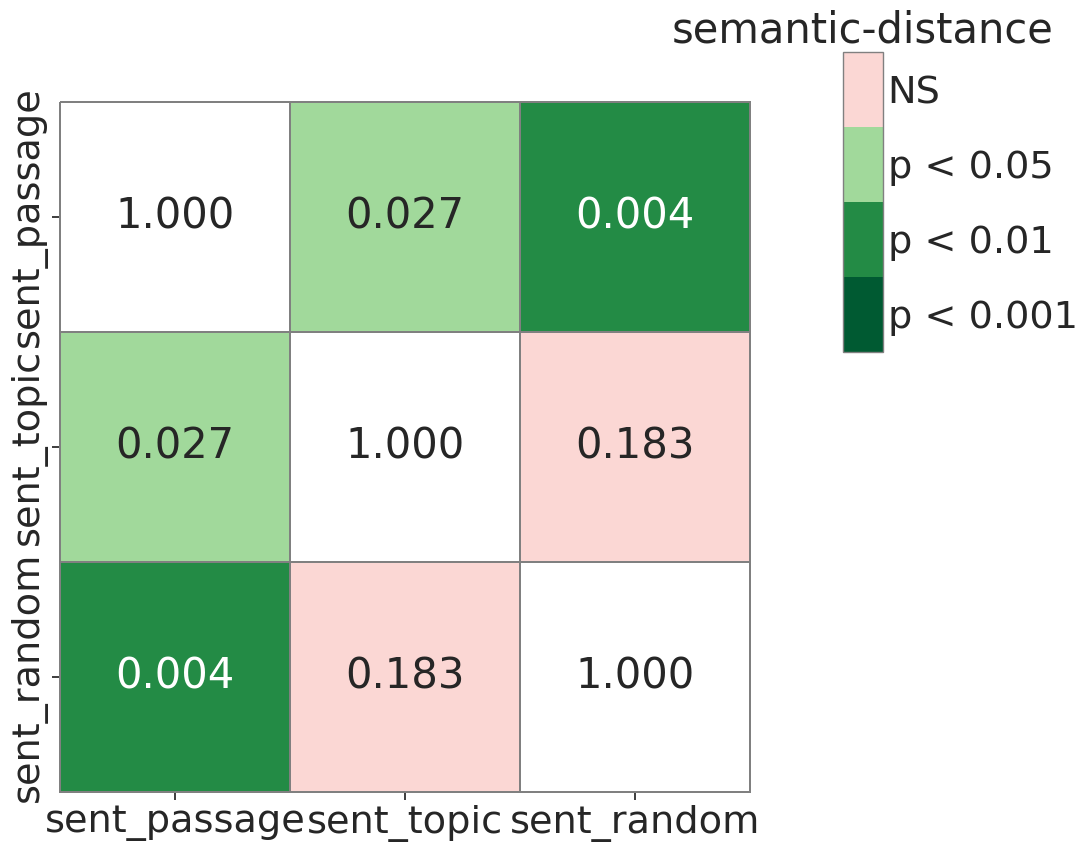

TrainPerturbed-TestPerturbed_decontextualized
word-order
['scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'backward', 'lowpmi', 'lowpmi-random']


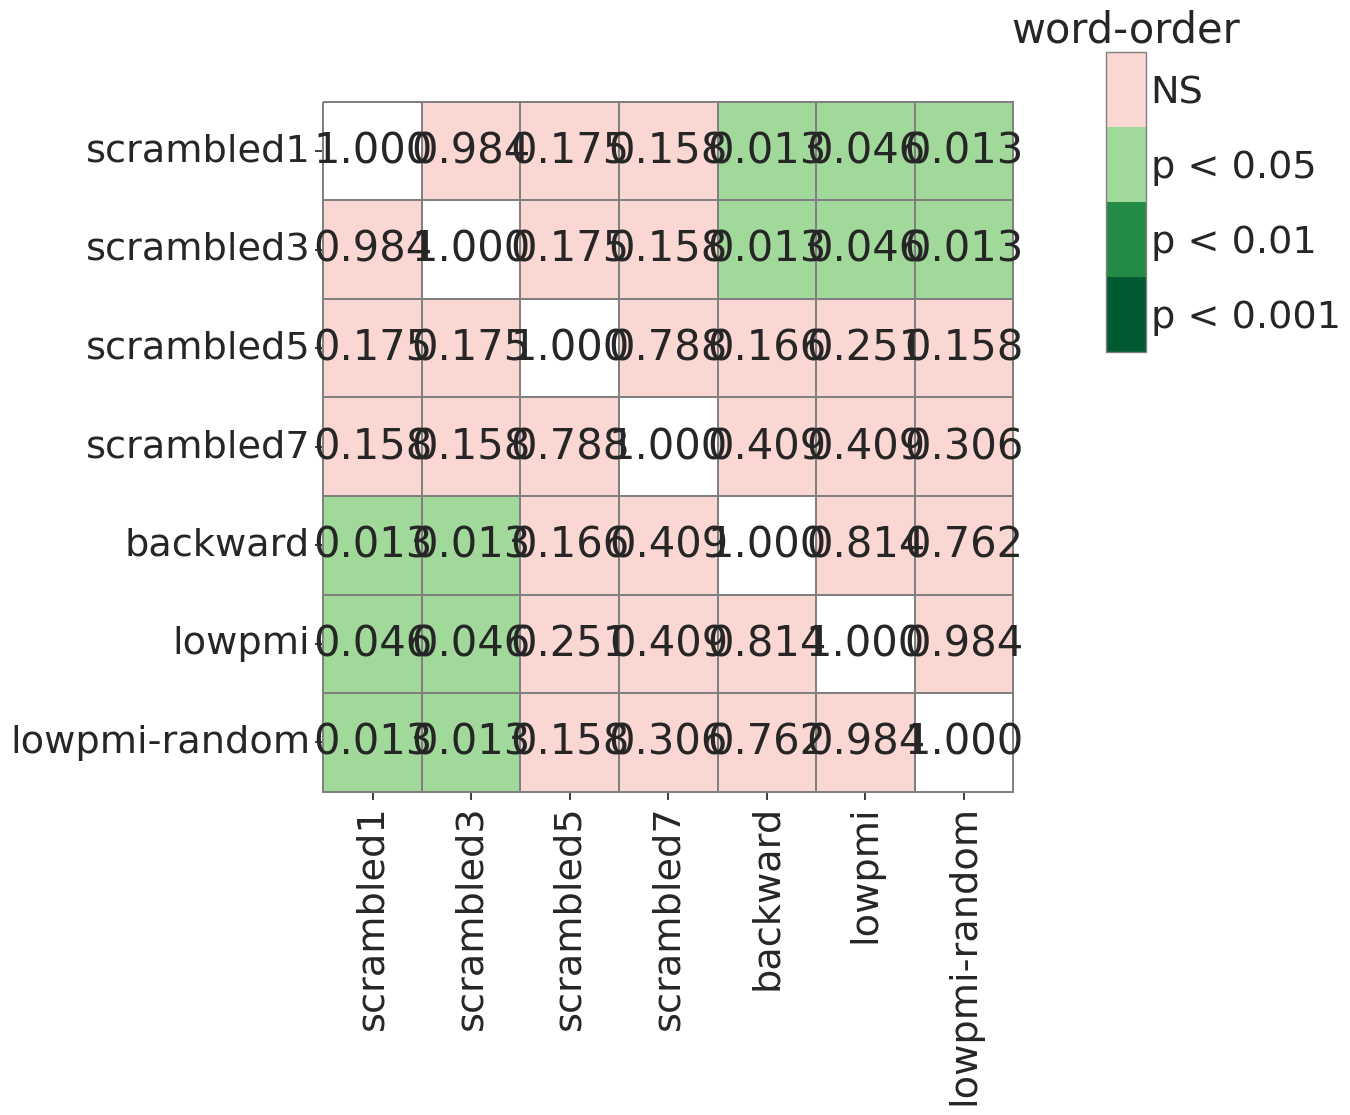

information-loss
['contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords']


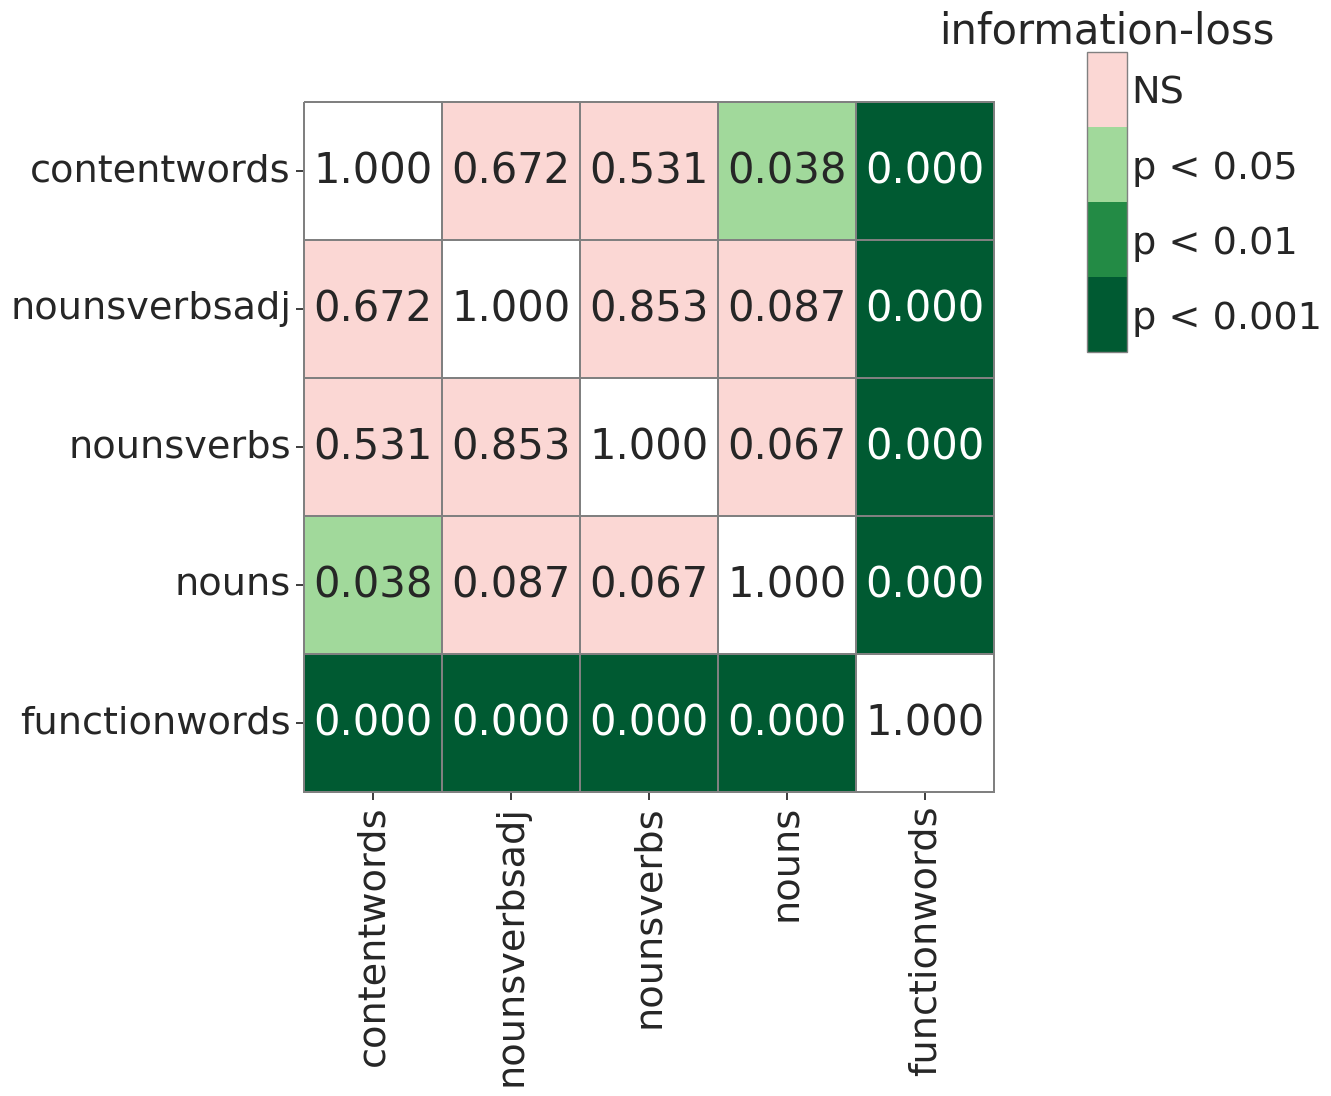

semantic-distance
['sent_passage', 'sent_topic', 'sent_random']


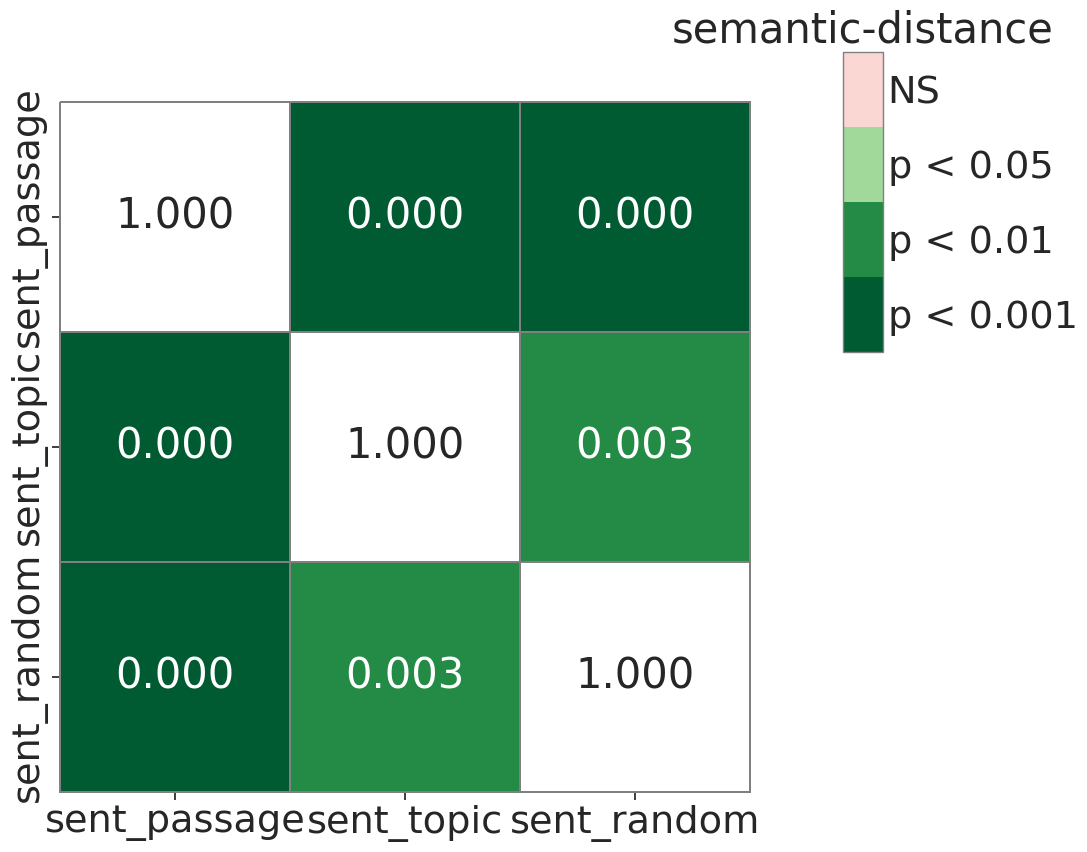

In [33]:
import scikit_posthocs as sp

score_conditions = full_stats_df["score_conditions"].unique()

CAT2COND["semantic-distance"] = ['sent_passage', 'sent_topic', 'sent_random']

for sc in score_conditions:
    print(sc)
    sub_df = full_stats_df.loc[full_stats_df["score_conditions"] == sc]
    for category in [x for x in categories if x not in ["original", "control"]]:
        print(category)
        
        print(CAT2COND[category])
        curr_df = sub_df[sub_df["condition"].isin(CAT2COND[category])]
        
        ttest = sp.posthoc_ttest(curr_df, val_col='values', group_col='condition', p_adjust='fdr_bh')

        plt.figure(figsize=(10,10))
        sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
        plt.subplots_adjust(top=0.8) 
        plt.title(f'{category}')

        ttest_df = pd.DataFrame(ttest)
        ttest_df["manipulation"] = [f"{category}"] * len(ttest_df)

        plt.show()